### Imports

In [2]:
from dataclasses import dataclass
from pathlib import Path
from Phishing_Detector.utils import *
from Phishing_Detector.constants import *
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
os.chdir('../')
#os.chdir('../DS_Projects/Phishing-Domain-Detection/')
os.getcwd()

'c:\\DS_Projects\\Phishing-Domain-Detection'

### Config Entity

In [72]:
@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir : Path
    x_test_file_path : Path
    y_test_file_path : Path
    saved_model_file_path : Path
    model_metrics_dir_path : Path
    model_metrics_json_file_path : Path
    model_metrics_cmat_file_path : Path

### Configuration

In [73]:
class ConfigurationManager:

    def __init__(
            self, 
            config_path = CONFIG_FILE_PATH,
            params_path = PARAMS_FILE_PATH
    ):
        self.config = read_yaml(config_path)
        self.params = read_yaml(params_path)
        create_directories([self.config.artifacts_root])

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        
        config = self.config.model_evaluation
        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir = config.root_dir,
            x_test_file_path = config.x_test_file_path,
            y_test_file_path = config.y_test_file_path,
            saved_model_file_path = config.saved_model_file_path,
            model_metrics_dir_path = config.model_metrics_dir_path,
            model_metrics_json_file_path = config.model_metrics_json_file_path,
            model_metrics_cmat_file_path = config.model_metrics_cmat_file_path
        )

        return model_evaluation_config



In [81]:
class ModelEvaluation:
    
    def __init__(self, config:ModelEvaluationConfig):
        print(f"{'>'*10} Starting Model Evaluation Stage! {'<'*10}")
        
        print(f"Getting Configuration for Model Evaluation Stage...")
        self.config = config
        print(f"Configurations : {config}")

        print(f"Creating required directories...")
        create_directories([self.config.model_metrics_dir_path])


    def evaluate_metrics(self):
        print(f"Loading training data...")
        x_test, y_test  = self._load_test_data()
        print(f"Testing data loaded successfully...")

        print(f"Loading model for evaluation...")
        model = self._load_model()
        print(f"Model loaded successfully...")

        print(f"Prediction on test data...")
        y_prob = model.predict(x_test)

        self._eval_and_save_metrics(actual = y_test,
                                    predicted = y_prob,
                                    save_metrics_path = Path(self.config.model_metrics_json_file_path),
                                    save_cmat_path = Path(self.config.model_metrics_cmat_file_path))

    def _load_test_data(self):
        x_test = pd.read_csv(Path(self.config.x_test_file_path))
        y_test = pd.read_csv(Path(self.config.y_test_file_path))

        return x_test, y_test

    def _load_model(self):
        with open(Path(self.config.saved_model_file_path), 'rb') as model_file:
            model = joblib.load(model_file)
        return model
    
    def _eval_and_save_metrics(self,actual, predicted, save_metrics_path, save_cmat_path):
        print(f"Starting metrics evaluation...")
        acc_score = round(accuracy_score(actual, predicted), 4)
        rec_score = round(recall_score(actual, predicted),4)
        prec_score = round(precision_score(actual, predicted),4)
        f1 = round(f1_score(actual, predicted))
        confusion_mat = confusion_matrix(actual, predicted)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])

        report = {
            "Accuracy Score" : acc_score,
            "Recall Score" : rec_score,
            "Precision Score" : prec_score,
            "F1 Score" : f1,
        }
        print(f"Evaluation Result : \n {report}")
        print(f"Confusion Matrix : \n {confusion_mat}")

        print(f"Saving Evaluation Report at {save_metrics_path}")
        save_json(path = Path(save_metrics_path), data = report)
        print(f"Evaluation Report saved at {save_metrics_path}")

        print(f"Saving Confusion Matrix Report at {save_cmat_path}")
        cm_display.plot()
        plt.savefig(Path(save_cmat_path))
        print(f"Confusion Matrix Report saved at {save_cmat_path}")




>>>>>>>>>> Starting Model Evaluation Stage! <<<<<<<<<<
Getting Configuration for Model Evaluation Stage...
Configurations : ModelEvaluationConfig(root_dir='model_evaluation', x_test_file_path='artifacts/data_transformation/train_test_data/x_test.csv', y_test_file_path='artifacts/data_transformation/train_test_data/y_test.csv', saved_model_file_path='artifacts/model_training/saved_models/model.joblib', model_metrics_dir_path='artifacts/model_evaluation/models_results', model_metrics_json_file_path='artifacts/model_evaluation/models_results/results.json', model_metrics_cmat_file_path='artifacts/model_evaluation/models_results/confusion_matrix.png')
Creating required directories...
Loading training data...
Testing data loaded successfully...
Loading model for evaluation...
Model loaded successfully...
Prediction on test data...
Starting metrics evaluation...
Evaluation Result : 
 {'Accuracy Score': 0.9652677279305355, 'Recall Score': 0.9860847564832385, 'Precision Score': 0.95468462951622

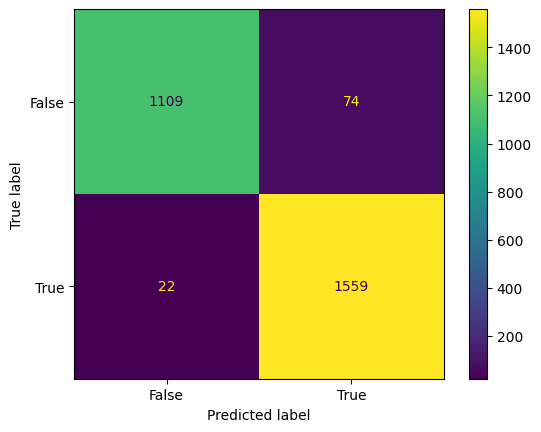

In [82]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config = model_evaluation_config)
    model_evaluation.evaluate_metrics()
except Exception as e:
    raise e